# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
import os
os.getcwd()

'C:\\Users\\emcyroyale\\Documents\\Projects\\Udacity_P2\\src'

In [3]:
from pathlib import Path
filename = Path("./envs/V1/Reacher_Windows_x86_64/Reacher.exe") 
filename_abs= filename.resolve()
env = UnityEnvironment(file_name=str(filename_abs))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [6]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
rewards_arr = []
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    rewards_arr.append(rewards)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.14999999664723873


When finished, you can close the environment.

In [7]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

# Reacher Training

### Initialization

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
from ddpg_agent import Agent

from collections import deque

In [2]:
from pathlib import Path
#filename = Path("./envs/V1/Reacher_Windows_x86_64/Reacher.exe") 
#filename = Path("./envs/V2/Reacher_Windows_x86_64/Reacher.exe") 
filename = Path("./envs/V2//Reacher.x86_64") 
filename_abs= filename.resolve()

train_mode=True
if train_mode:
    env = UnityEnvironment(file_name=str(filename_abs),no_graphics=True)
else:
    env = UnityEnvironment(file_name=str(filename_abs))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=train_mode)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Testing

In [4]:
from model import Actor

actor = Actor(state_size, action_size, 10)

In [5]:
env_info = env.reset(train_mode=train_mode)[brain_name]
states = env_info.vector_observations
print(states)

[[ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
   1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  7.90150833e+00 -1.00000000e+00
   1.25147629e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  -5.22214413e-01]
 [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
   1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  7.95617676e+00 -1.0000

In [7]:
action = actor(torch.Tensor([0.0]*33)).cpu().data.numpy()
print(action)

[ 0.05051129  0.08929446 -0.06335553 -0.00292262]


In [12]:
actions

array([[0.51927036, 0.5933739 , 0.39235297, 0.48155743]], dtype=float32)

In [99]:
from noise import OUNoise
noise = OUNoise(action_size,
                10,
                theta=0.0)

In [100]:
noise.state

array([0., 0., 0., 0.])

[0.27694477 0.25049559 0.24631277 0.07326556]


(array([1., 0., 0., 0., 0., 0., 0., 0., 2., 1.]),
 array([0.07326556, 0.09363348, 0.1140014 , 0.13436932, 0.15473724,
        0.17510516, 0.19547308, 0.21584101, 0.23620893, 0.25657685,
        0.27694477]),
 <BarContainer object of 10 artists>)

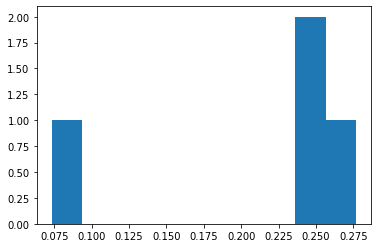

In [103]:
import  matplotlib.pyplot as plt
noise_sample = noise.sample()
print(noise_sample)
plt.hist(noise_sample)

In [28]:
agent.noise.theta

0.0

In [7]:
action_arr = []
rew_arr = []
agent_flag = True
add_noise = True
for i in range(0,50):
    
    if agent_flag:
        actions = agent.act(states, add_noise=add_noise)
    else:
        actions = actor(torch.Tensor(states)).cpu().data.numpy()
    action_arr.append(actions)
    env_info = env.step(actions)[brain_name]

    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    rew_arr.append(rewards)

    #if agent_flag:
    if False:
        if i % 20:
            agent.step(states,
                       actions,
                       rewards,
                       next_states,
                       dones,
                       add_replay_flag=True,
                       learn_flag=True,
                       learn_repeat=20)
    
    states = next_states
       
print(rewards, next_states, dones)


UnityEnvironmentException: No Unity environment is loaded.

In [13]:
agent.

In [14]:
print(action_arr[:1])

[array([[ 1.        ,  0.37400782,  1.        , -0.06015228],
       [ 1.        ,  0.37262875,  1.        ,  0.07936825],
       [ 1.        ,  0.36787456,  1.        , -0.02940028],
       [ 1.        ,  0.3733998 ,  1.        , -0.22704999],
       [ 1.        ,  0.37454087,  1.        , -0.2687871 ],
       [ 1.        ,  0.37553966,  1.        , -0.2624522 ],
       [ 1.        ,  0.3750924 ,  1.        ,  0.06552006],
       [ 1.        ,  0.37446493,  1.        , -0.36874104],
       [ 1.        ,  0.37557924,  1.        , -0.35304666],
       [ 1.        ,  0.37527448,  1.        , -0.17452036],
       [ 1.        ,  0.3663627 ,  1.        , -0.25196624],
       [ 1.        ,  0.36962432,  1.        , -0.04082804],
       [ 1.        ,  0.37491727,  1.        , -0.23542027],
       [ 1.        ,  0.37193263,  1.        ,  0.1594009 ],
       [ 1.        ,  0.37540686,  1.        , -0.4353397 ],
       [ 1.        ,  0.37303197,  1.        ,  0.23650266],
       [ 1.        ,  0

In [27]:
print(rew_arr)
print(np.sum(rew_arr))

[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
0.0


In [12]:
state = np.array([0.0]*33)
print(agent.act(state))
print(actor(torch.Tensor(state)))

[-0.1493105  -0.77480084  0.38520765  1.        ]
tensor([ 0.0505,  0.0893, -0.0634, -0.0029], grad_fn=<TanhBackward0>)


In [7]:
param_idx=0
print(list(agent.actor_target.parameters())[param_idx])
print(list(actor.parameters())[param_idx])

Parameter containing:
tensor([[-0.0348, -0.0680,  0.0637,  ..., -0.0008, -0.0275, -0.1072],
        [-0.0050, -0.1313,  0.1993,  ...,  0.0452,  0.0206, -0.0994],
        [ 0.0351, -0.0142,  0.0866,  ...,  0.0790, -0.0276, -0.0475],
        ...,
        [-0.0847,  0.0121,  0.1751,  ...,  0.1041, -0.0184,  0.0013],
        [-0.0764, -0.0695, -0.2532,  ...,  0.0835,  0.0157, -0.0692],
        [ 0.0429, -0.0906,  0.1116,  ...,  0.0153,  0.0488, -0.0588]],
       requires_grad=True)
Parameter containing:
tensor([[-0.0251,  0.0002,  0.0042,  ..., -0.0545, -0.0275, -0.0584],
        [-0.0123, -0.0667, -0.0829,  ..., -0.0569,  0.0206,  0.0140],
        [-0.0267,  0.0044,  0.0078,  ..., -0.0274, -0.0276,  0.0109],
        ...,
        [ 0.0313,  0.0088,  0.0586,  ...,  0.0444, -0.0184,  0.0299],
        [-0.0359, -0.0758, -0.0838,  ...,  0.0224,  0.0157, -0.0195],
        [ 0.0491, -0.0779,  0.0273,  ...,  0.0200,  0.0488, -0.0429]],
       requires_grad=True)


### Training

In [4]:
config = {'buffer_size' : int(1e6),
          'batch_size' : 128,
          'gamma' : 0.95,
          'tau' : 1e-3,
          'lr_actor' : 1e-4,
          'lr_critic' : 1e-5,
          'weight_decay' : 0.0 #0.000008,
          'theta' : 0.15,
          'num_agents' : 20,
          'random_seed' : 10}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
agent = Agent(state_size=state_size,
              action_size=action_size,
              random_seed=config['random_seed'],
              config=config,
              device=device)

cuda:0


In [5]:
load_model = True
actor_path = 'checkpoint_actor_12p78.pth'
critic_path = 'checkpoint_critic_12p78.pth'
#actor_path = 'checkpoint_actor_p98.pth'
#critic_path = 'checkpoint_critic_p98.pth'
#actor_path = 'checkpoint_actor_p73.pth'
#critic_path = 'checkpoint_critic_p73.pth'
#actor_path = 'checkpoint_actor.pth'
#critic_path = 'checkpoint_critic.pth'

if load_model:
    agent.actor_local.load_state_dict(torch.load(actor_path))
    agent.actor_target.load_state_dict(torch.load(actor_path))
    agent.critic_local.load_state_dict(torch.load(critic_path))
    agent.critic_target.load_state_dict(torch.load(critic_path))
    

In [6]:
ep_tot_ts = []

n_episodes=5000
max_t=1500
average_score_over=100
print_every=5

num_agents = len(env_info.agents)

In [7]:
import pickle
load_scores = True
if load_scores:
    scores_deque = pickle.load(open('scores_deque.pkl', 'rb'))
    scores = pickle.load(open('scores.pkl', 'rb'))
else:
    scores_deque = deque(maxlen=average_score_over)
    scores = []

In [9]:
avg_score = 0 
for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=train_mode)[brain_name]
    states = env_info.vector_observations
    agent.reset()
    agent_scores = np.zeros(num_agents) 
    #print(f'Starting Episode {i_episode}') 
    for t in range(max_t):
        #print(t)
        
        #noise_weight = np.clip(avg_score/30*-1+1.0, 0.0, 1.0)
        actions = agent.act(states, add_noise=True, noise_weight=1.0)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done

        if t%20 == 0:
            agent.step(states,
                       actions,
                       rewards,
                       next_states,
                       dones,
                       add_replay_flag=True,
                       learn_flag=True,
                       learn_repeat=40)
        else:
            agent.step(states,
                       actions,
                       rewards,
                       next_states,
                       dones,
                       add_replay_flag=True,
                       learn_flag=False,
                       learn_repeat=40)

        states = next_states
        agent_scores += rewards
        if True in dones:
            ep_tot_ts.append(t)
            break
            
        #if t % 100 == 0:
        #    print('\r {} ts \tAverage Score: {:.2f}, Noise: {}'.format(t, np.mean(agent_scores), 1))#agent.noise.state))
            

    avg_score = np.mean(agent_scores) 
    scores_deque.append(avg_score)   
    scores.append(avg_score)

    avg_100_scores = np.mean(scores_deque)
    
    #Save successful agents
    if avg_100_scores >= 30.0:
            print("Success!")
            torch.save(agent.actor_local.state_dict(), "successful_checkpoint_actor.pth")   
            torch.save(agent.critic_local.state_dict(), "successful_checkpoint_critic.pth") 

    #Save every 10 episodes
    if i_episode % 10 == 0:
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if True:
            avg_rewards_learning_sample = agent.mean_learning_sample_reward/ agent.n_learning_samples
            print('\rAverage Reward in Internal Learning Samples: {}'.format(avg_rewards_learning_sample))

    #Get average episodic scores
    if i_episode % print_every == 0:
        
        print('\rScore Queue {},\t Mean: {:.5f}'.format(scores_deque, avg_100_scores))
        print('\rEpisode {},\t Noise: {}'.format(i_episode,
                                                                      1.0))#agent.noise.state))


Score Queue deque([10.186499772313983, 12.196999727375806, 11.87799973450601, 14.723999670892955, 11.51449974263087, 10.499999765306711, 11.3969997452572, 12.062999730370938, 11.251999748498202, 13.37099970113486, 10.06749977497384, 11.904999733902514, 14.144499683845789, 13.269499703403563, 11.419499744754285, 12.377499723341316, 10.804499758500606, 12.712499715853482, 14.218999682180584, 12.668999716825784, 12.589499718602747, 13.446499699447305, 14.217999682202935, 15.142999661527574, 12.291499725263566, 10.551999764144421, 12.368999723531307, 14.199499682616443, 12.504999720491469, 13.130499706510454, 12.6734997167252, 12.020499731320887, 13.429499699827284, 15.435999654978513, 15.118499662075191, 14.163499683421104, 14.244999681599438, 13.598999696038664, 13.607499695848674, 12.536999719776214, 11.940499733109027, 12.028999731130899, 11.51349974265322, 13.105999707058071, 13.451499699335546, 12.899499711673707, 11.023499753605574, 12.447499721776694, 12.889999711886048, 14.1469996

KeyboardInterrupt: 

In [16]:
np.mean(scores_deque)

12.815749713545669

In [19]:
import pickle
pickle.dump(scores_deque, open('scores_deque.pkl', 'wb'))
pickle.dump(scores, open('scores.pkl', 'wb'))

In [11]:
env.close()

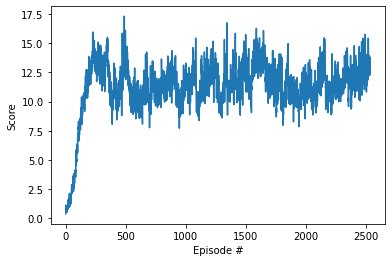

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Hyperparam Tuning Loop - Original Manual

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
from ddpg_agent import Agent

from collections import deque

from pathlib import Path
#filename = Path("./envs/V1/Reacher_Windows_x86_64/Reacher.exe") 
#filename = Path("./envs/V2/Reacher_Windows_x86_64/Reacher.exe") 
filename = Path("./envs/V2//Reacher.x86_64") 
filename_abs= filename.resolve()


train_mode=True
if train_mode:
    env = UnityEnvironment(file_name=str(filename_abs),no_graphics=True)
else:
    env = UnityEnvironment(file_name=str(filename_abs))



INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
env.port

5005

In [2]:
def run_configured_ddpg(env, config, training_name):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    # reset the environment
    env_info = env.reset(train_mode=train_mode)[brain_name]
    # number of agents
    num_agents = len(env_info.agents)
    print('Number of agents:', num_agents)
    # size of each action
    action_size = brain.vector_action_space_size
    print('Size of each action:', action_size)
    # examine the state space 
    states = env_info.vector_observations
    state_size = states.shape[1]
    print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
    print('The state for the first agent looks like:', states[0])
    
    agent = Agent(state_size=state_size,
                  action_size=action_size,
                  random_seed=config['random_seed'],
                  config=config,
                  device=device)

    
    ep_tot_ts = []
    n_episodes=500
    max_t=1500
    average_score_over=100
    print_every=20
    num_agents = len(env_info.agents)


    #Load model
    load_model = False
    actor_path = 'checkpoint_actor_12p78.pth'
    critic_path = 'checkpoint_critic_12p78.pth'
    #actor_path = 'checkpoint_actor_p98.pth'
    #critic_path = 'checkpoint_critic_p98.pth'
    #actor_path = 'checkpoint_actor_p73.pth'
    #critic_path = 'checkpoint_critic_p73.pth'
    #actor_path = 'checkpoint_actor.pth'
    #critic_path = 'checkpoint_critic.pth'

    if load_model:
        agent.actor_local.load_state_dict(torch.load(actor_path))
        agent.actor_target.load_state_dict(torch.load(actor_path))
        agent.critic_local.load_state_dict(torch.load(critic_path))
        agent.critic_target.load_state_dict(torch.load(critic_path))

    #Load Score
    import pickle
    load_scores = False
    if load_scores:
        scores_deque = pickle.load(open('scores_deque.pkl', 'rb'))
        scores = pickle.load(open('scores.pkl', 'rb'))
    else:
        scores_deque = deque(maxlen=average_score_over)
        scores = []

        #===================================================================
        def run_ddpg(agent, env, config, training_name):
            avg_score = 0
            bset_score = 0
            for i_episode in range(1, n_episodes+1):
                env_info = env.reset(train_mode=train_mode)[brain_name]
                states = env_info.vector_observations
                agent.reset()
                agent_scores = np.zeros(num_agents) 
                #print(f'Starting Episode {i_episode}') 
                for t in range(max_t):
                    #print(t)

                    #noise_weight = np.clip(avg_score/30*-1+1.0, 0.0, 1.0)
                    actions = agent.act(states, add_noise=True, noise_weight=1.0)
                    env_info = env.step(actions)[brain_name]
                    next_states = env_info.vector_observations
                    rewards = env_info.rewards
                    dones = env_info.local_done

                    if t%config['train_every_ts'] == 0:
                        agent.step(states,
                                   actions,
                                   rewards,
                                   next_states,
                                   dones,
                                   add_replay_flag=True,
                                   learn_flag=True,
                                   learn_repeat=config['train_repeated'])
                    else:
                        agent.step(states,
                                   actions,
                                   rewards,
                                   next_states,
                                   dones,
                                   add_replay_flag=True,
                                   learn_flag=False,
                                   learn_repeat=config['train_repeated'])

                    states = next_states
                    agent_scores += rewards
                    if True in dones:
                        ep_tot_ts.append(t)
                        break

                    #if t % 100 == 0:
                    #    print('\r {} ts \tAverage Score: {:.2f}, Noise: {}'.format(t, np.mean(agent_scores), 1))#agent.noise.state))


                avg_score = np.mean(agent_scores) 
                scores_deque.append(avg_score)   
                scores.append(avg_score)

                avg_100_scores = np.mean(scores_deque)

                #Save successful agents
                if avg_100_scores >= 30.0:
                        print("Success!")
                        torch.save(agent.actor_local.state_dict(), "successful_checkpoint_actor_"+training_name+".pth")   
                        torch.save(agent.critic_local.state_dict(), "successful_checkpoint_critic_"+training_name+".pth") 

                #Save every 10 episodes if current episodes greater than 
                if i_episode % 10 == 0:
                    torch.save(agent.actor_local.state_dict(), "checkpoint_actor_"+training_name+".pth")
                    torch.save(agent.critic_local.state_dict(), "checkpoint_critic_"+training_name+".pth")

                    if avg_score > best_score:
                        torch.save(agent.actor_local.state_dict(), "checkpoint_actor_best_"+training_name+".pth")
                        torch.save(agent.critic_local.state_dict(), "checkpoint_critic_best_"+training_name+".pth")
                        
                    
                    if False:
                        print("Learning Samples: mean: {} : n_sample : {}".format(agent.mean_learning_sample_reward, agent.n_learning_samples))
                        avg_rewards_learning_sample = agent.mean_learning_sample_reward/ agent.n_learning_samples
                        print('\rAverage Reward in Internal Learning Samples: {}'.format(avg_rewards_learning_sample))

                #Get average episodic scores
                if i_episode % print_every == 0:

                    print('\rScore Queue {},\t Mean: {:.5f}'.format(scores_deque, avg_100_scores))
                    print('\rEpisode {},\t Noise: {}'.format(i_episode,1.0))#agent.noise.state))

            return scores
        #===================================================================

    return run_ddpg(agent, env, config, training_name)




In [ ]:
config = {'buffer_size' : int(1e6),
          'batch_size' : 128,
          'gamma' : 0.95,
          'tau' : 1e-3,
          'lr_actor' : 1e-3,
          'lr_critic' : 1e-4,
          #'weight_decay' : 0.0,
          'weight_decay' : 0.000008,
          'theta' : 0.15,
          'num_agents' : 20,
          'random_seed' : 10,
          'train_every_ts' : 20,
          'train_repeated' : 20}


tuning_run_scores = {}
for train_every_ts in np.arange(10,20+1, step=10):
    config['train_every_ts'] = train_every_ts
    
    for train_repeated in np.arange(10, 40+1, step=10):
        config['train_repeated'] = train_repeated
    
        for i in range(3):
            print('====================================================================')
   
        training_name='_tet_' +str(train_every_ts)+ '_tr_' +str(train_repeated)
        print(training_name)
        
        score = run_configured_ddpg(env, config, training_name)
        tuning_run_scores[training_name] = score

_tet_10_tr_10
cuda:0
Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
Score Queue deque([0.4349999902769923, 0.38299999143928287, 0.32899999264627694, 0.270999993942678, 0.08549999808892608, 0.04699999894946814, 0.16449999632313847, 0.1169999973848462, 0.15499999653548002, 0.3109999930486083, 0.3584999919869006, 0.3109999930486083, 0.3119999930262566, 0.1914999957

In [ ]:
tuning_run_scores

In [1]:
import pickle

fstr='/data1/Projects/ray_results/MyTrainable_2023-10-07_21-54-10/MyTrainable_947f8_00000_0_batch_size=64,lr_actor=0.0100,lr_critic=0.0010_2023-10-07_21-54-13/scores_lrA_0.01_lrC_0.001_5.pkl'

score = pickle.load(open(fstr, 'rb'))

In [2]:
score

[0.0, 0.0, 0.0, 0.0, 0.0]

# Hyperparam Tuning Loop

In [2]:
def run_configured_ddpg(env, config):

    training_name=config['training_name']


    os.makedirs(config['training_name'], exist_ok=True)
    checkpoint_dir = training_name + '/'
    #training_name='_bz_' +str(config['batch_size'])+ '_lrA_' +str(config['lr_actor'])+ '_lrC_' +str(config['lr_critic'])
    #==========================================================================
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)


    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    print('Brain Name:', brain_name)
    print('Port:', env.port)
    # reset the environment
    env_info = env.reset(train_mode=config['train_mode'])[brain_name]
    # number of agents
    num_agents = len(env_info.agents)
    print('Number of agents:', num_agents)
    # size of each action
    action_size = brain.vector_action_space_size
    print('Size of each action:', action_size)
    # examine the state space 
    states = env_info.vector_observations
    state_size = states.shape[1]
    print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
    print('The state for the first agent looks like:', states[0])

    #ep_tot_ts = []
    num_agents = len(env_info.agents)
    config['num_agents']=num_agents


    agent = Agent(state_size=state_size,
                  action_size=action_size,
                  random_seed=config['random_seed'],
                  config=config,
                  device=device)

    #Loading===============================
    #Load model
    load_model = config['load_model']
    actor_path = 'checkpoint_actor_12p78.pth'
    critic_path = 'checkpoint_critic_12p78.pth'
    #actor_path = 'checkpoint_actor_p98.pth'
    #critic_path = 'checkpoint_critic_p98.pth'
    #actor_path = 'checkpoint_actor_p73.pth'
    #critic_path = 'checkpoint_critic_p73.pth'
    #actor_path = 'checkpoint_actor.pth'
    #critic_path = 'checkpoint_critic.pth'

    if load_model:
        agent.actor_local.load_state_dict(torch.load(actor_path))
        agent.actor_target.load_state_dict(torch.load(actor_path))
        agent.critic_local.load_state_dict(torch.load(critic_path))
        agent.critic_target.load_state_dict(torch.load(critic_path))

        
    average_score_over=config['average_score_over']
    #Load Score
    import pickle
    load_scores = config['load_scores']
    if load_scores:
        scores_deque = pickle.load(open('scores_deque.pkl', 'rb'))
        scores = pickle.load(open('scores.pkl', 'rb'))
    else:
        scores_deque = deque(maxlen=average_score_over)
        scores = []
    #=======================================
    best_score = 0.0
    
    add_params = {'num_agents': num_agents,
                  'brain_name': brain_name
                 }
    
    results = {'scores': scores,
               'scores_deque': scores_deque,
               'best_score' : best_score}
    print("===================================================================")
    
    #===================================================================
    def run_ddpg(agent, env, config, results, add_params):
        #===================================================================
        
        print("Training with:")
        print('Batch Size', config['batch_size'])
        print('LR Actor', config['lr_actor'])
        print('LR Critic', config['lr_critic'])
        print('Train Every ts', config['train_every_ts'])
        print('Train Repeated', config['train_repeated'])
        for i_episode in range(config['training_episodes']):
            #=================================================================== Single Episode
            env_info = env.reset(train_mode=config['train_mode'])[add_params['brain_name']]
            states = env_info.vector_observations
            agent.reset()
            agent_scores = np.zeros(add_params['num_agents']) 
            #print(f'Starting Episode {i_episode}') 
            for t in range(config['max_t']):
                #print(t)

                #noise_weight = np.clip(avg_score/30*-1+1.0, 0.0, 1.0)
                actions = agent.act(states, add_noise=True, noise_weight=1.0)
                env_infos_avail = env.step(actions)
                #print('Env Infos', env_infos_avail)
                env_info = env_infos_avail[add_params['brain_name']]
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = env_info.local_done
                
                #print(actions, rewards, states)

                if t%config['train_every_ts'] == 0:
                    agent.step(states,
                               actions,
                               rewards,
                               next_states,
                               dones,
                               add_replay_flag=True,
                               learn_flag=True,
                               learn_repeat=config['train_repeated'])
                else:
                    agent.step(states,
                               actions,
                               rewards,
                               next_states,
                               dones,
                               add_replay_flag=True,
                               learn_flag=False,
                               learn_repeat=config['train_repeated'])

                states = next_states
                agent_scores += rewards
                #print(type(rewards), type(states), type(agent_scores), np.array(rewards))
                #if True in dones:
                #    ep_tot_ts.append(t)
                #    break

                #if t % 100 == 0:
                #    print('\r {} ts \tAverage Score: {:.2f}, Noise: {}'.format(t, np.mean(agent_scores), 1))#agent.noise.state))
            #===================================================================

            #print(agent_scores)
            #print(add_params['num_agents'])
            avg_score = np.mean(agent_scores) 
            results['scores_deque'].append(avg_score)   
            results['scores'].append(avg_score)
            avg_100_scores = np.mean(results['scores_deque'])

            #Save successful agents
            if avg_100_scores >= 30.0 and i_episode > config['average_score_over']:
                    print("Success!")
                    torch.save(agent.actor_local.state_dict(), checkpoint_dir+"successful_checkpoint_actor"+training_name+"_"+str(i_episode)+".pth")   
                    torch.save(agent.critic_local.state_dict(), checkpoint_dir+"successful_checkpoint_critic"+training_name+"_"+str(i_episode)+".pth") 
                    pickle.dump(results['scores'], open(checkpoint_dir+'successful_scores'+training_name+"_"+str(i_episode)+'.pkl', 'wb'))
            if avg_score > results['best_score']:
                print("Saving New Best Score: {}".format(avg_score))
                torch.save(agent.actor_local.state_dict(), checkpoint_dir+"checkpoint_actor_best"+training_name+".pth")
                torch.save(agent.critic_local.state_dict(), checkpoint_dir+"checkpoint_critic_best"+training_name+".pth")
                results['best_score'] = avg_score
                    
            #Episode Stdout Logging
            if i_episode % config['print_every'] == 0:
                print("===================================================================")

                np.set_printoptions(precision=10)
                print('\rEpisode {},\t Episode Average Score: {:.10f},\t Best Score: {:.10f} '.format(i_episode,avg_score, results['best_score']))#agent.noise.state))
                print('\rEpisode Agent Scores {}'.format(agent_scores))
                
                print('\rMean Over 100: {:.10f}, Current Episode Mean: {:.10f}'.format(avg_100_scores,avg_score))
                print('\rScore Queue :', results['scores_deque'])
                print("Agent Buffer Length", agent.n_learning_samples)
                print("Agent Noise State Mean:", np.mean(agent.noise.state), "Stdv: ", np.std(agent.noise.state))

            
            #Checkpoint
            if i_episode % config['checkpoint_every_n_episodes'] == 0:
                torch.save(agent.actor_local.state_dict(), checkpoint_dir+"checkpoint_actor"+training_name+"_"+str(i_episode)+".pth")
                torch.save(agent.critic_local.state_dict(), checkpoint_dir+"checkpoint_critic"+training_name+"_"+str(i_episode)+".pth")
                pickle.dump(results['scores'], open(checkpoint_dir+'scores'+training_name+"_"+str(i_episode)+'.pkl', 'wb'))
                
         
        #==========================================================================
        
        torch.save(agent.actor_local.state_dict(), checkpoint_dir+"checkpoint_actor_fin"+training_name+"_"+str(i_episode)+".pth")
        torch.save(agent.critic_local.state_dict(), checkpoint_dir+"checkpoint_critic_fin"+training_name+"_"+str(i_episode)+".pth")
        pickle.dump(results['scores'], open(checkpoint_dir+'scores'+training_name+"_"+str(i_episode)+'.pkl', 'wb'))
        
    #===================================================================
    
    

    run_ddpg(agent, env, config, results, add_params)
    return results




In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
from ddpg_agent import Agent

from collections import deque

from pathlib import Path
import os 

In [3]:
#filename = Path("./envs/V1/Reacher_Windows_x86_64/Reacher.exe") 
#filename = Path("./envs/V2/Reacher_Windows_x86_64/Reacher.exe") 
filename = Path("/mnt/data1/Projects/Udacity_RL/p2/envs/V2/Reacher.x86_64") 
filename_abs= filename.resolve()

def start_unity_env(filename, no_graphics=True):
    env = None

    def start_unity_env_id(filename, no_graphics=True, worker_id=0):
        try:
            env = UnityEnvironment(file_name=str(filename_abs),no_graphics=no_graphics, worker_id=worker_id)
            print("Started UnityEnvironment on worker id {}".format(worker_id))
            return True, env
        except UnityTimeOutException as e:
            print(e)
            return False, None

    max_worker_id=10
    for i in range(max_worker_id):
        env_started, env = start_unity_env_id(filename, no_graphics=no_graphics, worker_id=i)
        if env_started:
            print(env)
            return env
        time.sleep(1)

    return None

In [ ]:
base_config = {'buffer_size' : int(1e6),
          'batch_size' : [128],
          'gamma' : 0.95,
          'tau' : 1e-3,
          #'lr_actor' : 1e-3,
          #'lr_critic' : 1e-4,
          'lr_actor' : [1e-3],
          'lr_critic' : [1e-4],
          #'weight_decay' : 0.0,
          'weight_decay' : 0.000008,
          'theta' : 0.15,
          'num_agents' : 20,
          'random_seed' : 15,
          'train_every_ts' : [10,20],
          'train_repeated' : [40,20,50],
          'checkpoint_every_n_episodes': 50,
          'print_every' : 1,
          'training_episodes' : 500,
          'max_t' : 1500,
          'ray_tune' : True,
          'train_mode' : True,
          'load_model' : False,
          'load_scores' : False,
          'average_score_over' : 100}




env = start_unity_env(filename=str(filename_abs), no_graphics=base_config['train_mode'])

tuning_results = {}

from copy import deepcopy
for bz_idx, bz in enumerate(base_config['batch_size']):
    for lra_idx, lra in enumerate(base_config['lr_actor']):
        for lrc_idx, lrc in enumerate(base_config['lr_critic']):
            for tet_idx, tet in enumerate(base_config['train_every_ts']):
                for tr_idx, tr in enumerate(base_config['train_repeated']):
                    
                    config = deepcopy(base_config)
                    config['batch_size'] = bz
                    config['lr_actor'] = lra
                    config['lr_critic'] = lrc
                    config['train_every_ts'] = tet
                    config['train_repeated'] = tr

                    tuning_run_results = []
                    print('Tuning Run Index', str(bz_idx),str(lra_idx),str(lrc_idx),str(tet_idx),str(tr_idx))
                    print('Batch Size: ', bz, ' LR Actor: ', lra, ' LR Critic: ', lrc, ' Train Every ts: ', tet, ' N_Train_Repeat: ', tr)
                    training_name = 'TUNE1_bz_' +str(config['batch_size'])+ '_lrA_' +str(config['lr_actor'])+ '_lrC_' +str(config['lr_critic'])+ '_tet_' +str(config['train_every_ts'])+ '_tr_' +str(config['train_repeated'])
                    config['training_name'] = training_name


                    tuning_results[config['training_name']]=run_configured_ddpg(env, config)

                    print('Tuning Run Index', str(bz_idx * lra_idx * lrc_idx), ' Done')
print(len(tuning_results))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Started UnityEnvironment on worker id 0
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Tuning Run Index 0 0 0 0 0
Batch Size:  128  LR Actor:  0.001  LR Critic:  0.0001  Train Every ts:  10  N_Train_Repeat:  40
cuda:0
Brain Name: ReacherBrain
Port: 5005
Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000

In [1]:
print(1e-2)

0.01


In [5]:
import numpy as np
np.std(np.ones((4,5)))

0.0

In [1]:
import numpy as np
results = {'scores_deque': [],
           'scores': []}
agent_scores = [1.00005,45.323423,65.33332222]

avg_score = np.mean(agent_scores) 
results['scores_deque'].append(avg_score)   
results['scores'].append(avg_score)
avg_100_scores = np.mean(scores_deque)


print'\rEpisode Agent Scores {}'.format(agent_scores))
print('\rScore Queue {},\t Mean: {:.5f}'.format(scores_deque, avg_100_scores))
print('\rEpisode {},\t Episode Average Score: {}'.format(i_episode,avg_score))#agent.noise.state))

SyntaxError: invalid syntax (<ipython-input-1-0ca99b6bd201>, line 12)

In [8]:

def outer():
    x=1
    d={'hi': 2}
    a=[1,2,3,{'p', "name"}]
    h={'x': x}
    print(x, d, a, h)
    def inner(x,d,a, h):
        print(x, d, a, h)
        x=3
        d['hi']=5
        a[2]=4
        i=h
        print(i)
        h['x']=6
        h['p']=55
        print(x, d, a, h,i)
    inner(x,d,a, h)
    print(x, d, a, h)
    
outer()

1 {'hi': 2} [1, 2, 3, {'p', 'name'}] {'x': 1}
1 {'hi': 2} [1, 2, 3, {'p', 'name'}] {'x': 1}
{'x': 1}
3 {'hi': 5} [1, 2, 4, {'p', 'name'}] {'x': 6, 'p': 55} {'x': 6, 'p': 55}
1 {'hi': 5} [1, 2, 4, {'p', 'name'}] {'x': 6, 'p': 55}
